In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

from tqdm.auto import tqdm

c:\Users\kamal\anaconda3\envs\torchenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## HELPER FUNCTIONS

In [2]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## MAKING DATASET

In [3]:
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

In [4]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Image shape: torch.Size([1, 28, 28])


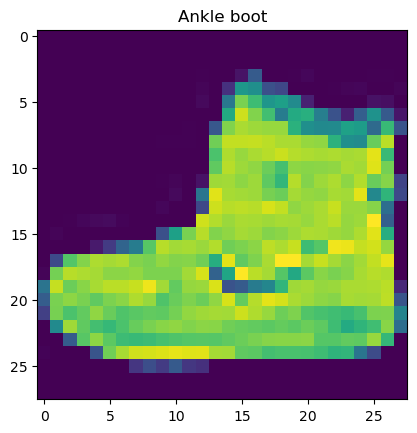

In [5]:
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze()) # image shape is [1, 28, 28] (colour channels, height, width)
plt.title(class_names[label]);

In [6]:
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## BUILDING A MODEL (NON_LINEAR)

In [8]:
class modelMNIST(nn.Module):
    def __init__(self , input_shape , hidden_units , output_shape):
        super().__init__()

        self.layer_stack = nn.Sequential(
            nn.Flatten() , 

            nn.Linear(in_features = input_shape , out_features = hidden_units),
            nn.ReLU(),

            nn.Linear(in_features = hidden_units , out_features = output_shape),
            nn.ReLU()
        )
    
    def forward(self , X):
        return self.layer_stack(X)
    


In [9]:
torch.manual_seed(42)

model = modelMNIST(28*28 , 10 , len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params = model.parameters() , lr = 0.01)



## TRAINING/TESTING LOOP FUNCTION

In [10]:
def train_step(model , dataloader , loss_fn , optimizer , accuracy_fn , device):

    train_loss , train_acc = 0 , 0

    model.train()

    for batch , (X,y) in enumerate(dataloader):
        X , y = X.to(device) , y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred , y)

        train_loss += loss

        train_acc += accuracy_fn(y , y_pred.argmax(dim = 1))

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(dataloader)

    train_acc /= len(dataloader)

    print(f"Train Loss: {train_loss:.5f} | Train Acc : {train_acc:.2f}%")

def test_step(model , dataloader , loss_fn , accuracy_fn , device):

    test_loss , test_acc = 0 , 0

    model.eval()

    with torch.inference_mode():
        for X,y in dataloader:
            X , y = X.to(device) , y.to(device)

            test_pred = model(X)

            loss = loss_fn(test_pred , y)

            test_loss += loss 

            test_acc += accuracy_fn(y , test_pred.argmax(dim = 1))


        test_loss /= len(dataloader)

        test_acc /= len(dataloader)

        print(f"Test Loss: {test_loss:.5f} | Test Acc : {test_acc:.2f}%")

def eval_model(model, data_loader, loss_fn, accuracy_fn,
               device):

    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [11]:
EPOCHS = 3

for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n---------------")
    train_step(model , train_dataloader , loss_fn , optimizer , accuracy_fn , device)
    test_step(model , test_dataloader , loss_fn , accuracy_fn , device)

model_results = eval_model(model , test_dataloader , loss_fn , accuracy_fn , device)
model_results

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------------
Train Loss: 0.63093 | Train Acc : 77.79%


 33%|███▎      | 1/3 [00:13<00:27, 13.79s/it]

Test Loss: 0.54821 | Test Acc : 80.66%
Epoch: 1
---------------
Train Loss: 0.51536 | Train Acc : 81.78%


 67%|██████▋   | 2/3 [00:25<00:12, 12.67s/it]

Test Loss: 0.53342 | Test Acc : 81.50%
Epoch: 2
---------------
Train Loss: 0.49797 | Train Acc : 82.51%


100%|██████████| 3/3 [00:37<00:00, 12.51s/it]

Test Loss: 0.55850 | Test Acc : 81.10%


{'model_name': 'modelMNIST',
 'model_loss': 0.5585033893585205,
 'model_acc': 81.10023961661342}